# Imports 

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, f1_score, precision_recall_fscore_support, precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor

from imblearn.pipeline import Pipeline as Pipeline_Imblearn

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Import the dataset 

In [3]:
sales_data = pd.read_csv('sales_data.csv', parse_dates=True)

First, let's create a binary variable that indicates if there were sales for that specific product at a specific store given the weather conditions. 

In [4]:
sales_data['sales'] = sales_data.units.apply(lambda x: 1 if x >0 else 0)

In [5]:
sales_data.head()

,date,item_nbr,store_nbr,station_nbr,tmax,preciptotal,stnpressure,avgspeed,units,RA,...,TS,VCTS,DZ,weekend,previous_units,month,month_sin,month_cos,city,sales
0,2012-01-01,5,1,1,52.0,0.05,29.78,4.6,0,1.0,...,0.0,0.0,0.0,1,0.0,1,0.5,0.866025,1,0
1,2012-01-02,5,1,1,50.0,0.01,29.44,10.3,0,0.0,...,0.0,0.0,0.0,0,0.0,1,0.5,0.866025,1,0
2,2012-01-03,5,1,1,32.0,0.00,29.67,11.6,0,0.0,...,0.0,0.0,0.0,0,0.0,1,0.5,0.866025,1,0
3,2012-01-04,5,1,1,28.0,0.00,29.86,8.3,0,0.0,...,0.0,0.0,0.0,0,0.0,1,0.5,0.866025,1,0
4,2012-01-05,5,1,1,38.0,0.00,29.67,7.8,0,0.0,...,0.0,0.0,0.0,0,0.0,1,0.5,0.866025,1,0


# Test pipeline for fitting classification

Define our dataset with relevant predictors 

In [6]:
# Create feature matrices
X = sales_data[(sales_data.item_nbr == 5) & (sales_data.city == 2)].reset_index(drop=True)

#Create our y value
y = X.sales.reset_index(drop=True)

#Remove some columns
X = X.drop(columns=['sales','item_nbr', 'city', 'units', 'stnpressure', 
                    'date', 'store_nbr', 'station_nbr', 'month'])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

Create pipeline with a logistic regression estimator (there could be room for more here). 

In [8]:
# Create estimator
log_clasifier = LogisticRegression()

# Pipeline
pipe = Pipeline([('estimator', log_clasifier)])

pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('estimator',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [9]:
#Train
precision_recall_fscore_support(y_train, pipe['estimator'].predict(X_train))

(array([0.94312084, 0.9955708 ]),
 array([0.99299435, 0.96336237]),
 array([0.96741524, 0.9792018 ]),
 array([4425, 7233], dtype=int64))

In [10]:
# Test
precision_recall_fscore_support(y_test, pipe['estimator'].predict(X_test))

(array([0.93965517, 0.997151  ]),
 array([0.99543379, 0.96153846]),
 array([0.96674058, 0.97902098]),
 array([1095, 1820], dtype=int64))

# Pipeline for fitting regression part

In [14]:
# Create feature matrices
X = sales_data[(sales_data.item_nbr == 45) & (sales_data.city == 1)].reset_index(drop=True)

#Set target
y = X.units.reset_index(drop=True)

X = X.drop(columns=['sales','item_nbr', 'city', 'units', 'stnpressure', 
                    'date', 'store_nbr', 'station_nbr', 'month'])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [16]:
# Scaling
scaler = StandardScaler()    

# Create pipeline
lreg = LinearRegression()

# Pipeline
pipe = Pipeline([('estimator', lreg)])

pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('estimator',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [17]:
#Train
r2_score(y_train, pipe['estimator'].predict(X_train))

0.8576538098900706

In [18]:
# Test
r2_score(y_test, pipe['estimator'].predict(X_test))

0.8621586911531867

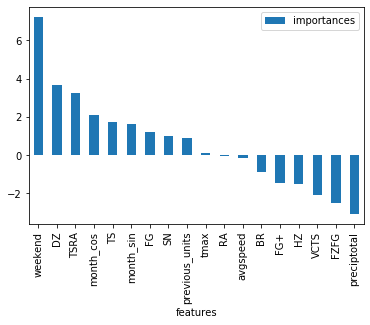

In [19]:
pd.DataFrame({'features': X.columns.to_list(),
'importances': pipe['estimator'].coef_}).sort_values(by='importances', ascending=False)\
.set_index('features').plot(kind='bar')

## Fitting all models 

In [21]:
def fit_subdf(df, product, city):
    """
    Takes a dataframe and slices it according to the columns and and values for querying the dataframe. 
    After that, it fits a pipeline and returns the fitted pipeline to the subset dataframe from the
    specified parameters.
    
    (doctest missing)
    
    """
    
    # Create feature matrices
    X = df[(df.item_nbr == product) & (df.city == city)].reset_index(drop=True)

    #Set y value for classification step
    y_clf = X.sales.reset_index(drop=True)
    
    #Set y value for regression step target
    y_reg = X.units.reset_index(drop=True)

    #Remove some columns
    X = X.drop(columns=['sales','item_nbr', 'city', 'units', 'stnpressure', 
                        'date', 'store_nbr', 'station_nbr', 'month'])
    
    if y_clf.nunique()<2:
        return {'clf' : None,
                'reg' : None}
    
    #Split for both estimators
    X_train, X_test, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=4)
    _, _, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=4)
    
    # Create estimator for classification step
    clf_pipe = Pipeline([('clf', LogisticRegression(class_weight='balanced'))])
    
    #Create estimator for regression step
    reg_pipe = Pipeline([('regressor', LinearRegression())])
    
    #Fit both regressors
    clf_pipe.fit(X_train, y_train_clf)
    reg_pipe.fit(X_train, y_train_reg)
    
    #Get classification model scores
    clf_train_score = f1_score(y_train_clf, clf_pipe.predict(X_train))
    clf_test_score = f1_score(y_test_clf, clf_pipe.predict(X_test))    
    
    # Get hurdle model scores
    train_predicted = clf_pipe.predict(X_train) * reg_pipe.predict(X_train)  
    test_predicted = clf_pipe.predict(X_test) * reg_pipe.predict(X_test)
        
    train_score = r2_score(y_train_reg, train_predicted)
    test_score = r2_score(y_test_reg, test_predicted)
    
    return {'clf': clf_pipe,
            'reg': reg_pipe,
            'clf_train_score': clf_train_score,
            'clf_test_score': clf_test_score,
            'train_score': train_score,
            'test_score': test_score,
            'class_balance': y_clf.value_counts(),
            'features': X.columns
           }


Apply the fitting method created before for each prodcut, city combination:

In [22]:
models_dict = {}
for product in sales_data.item_nbr.unique():
    for city in sales_data.city.unique():
        # Add dictionary key with modeling outcome
        models_dict['_'.join([str(product), str(city)])] = fit_subdf(sales_data, product, city) 


## Comparing feature importances across cities and products

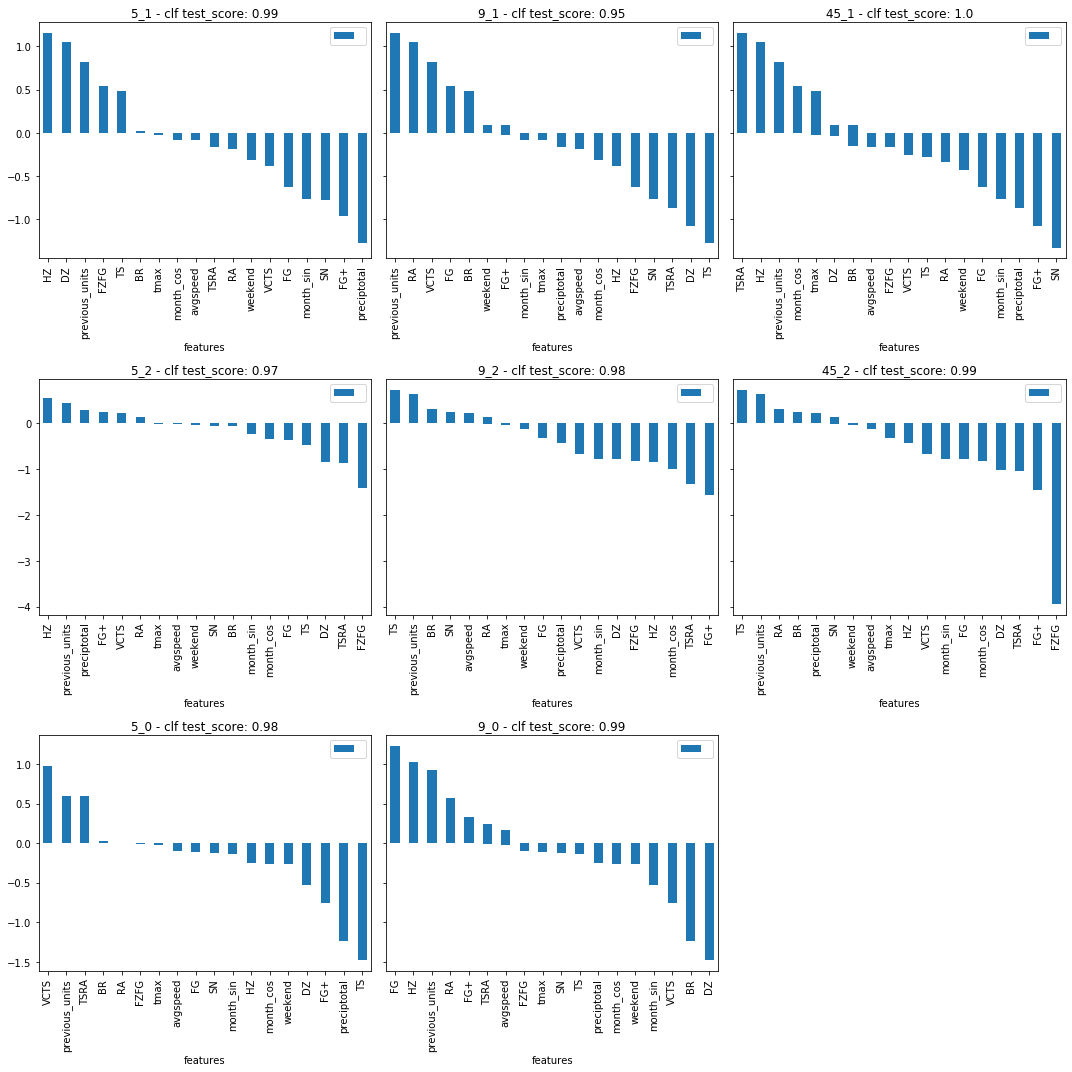

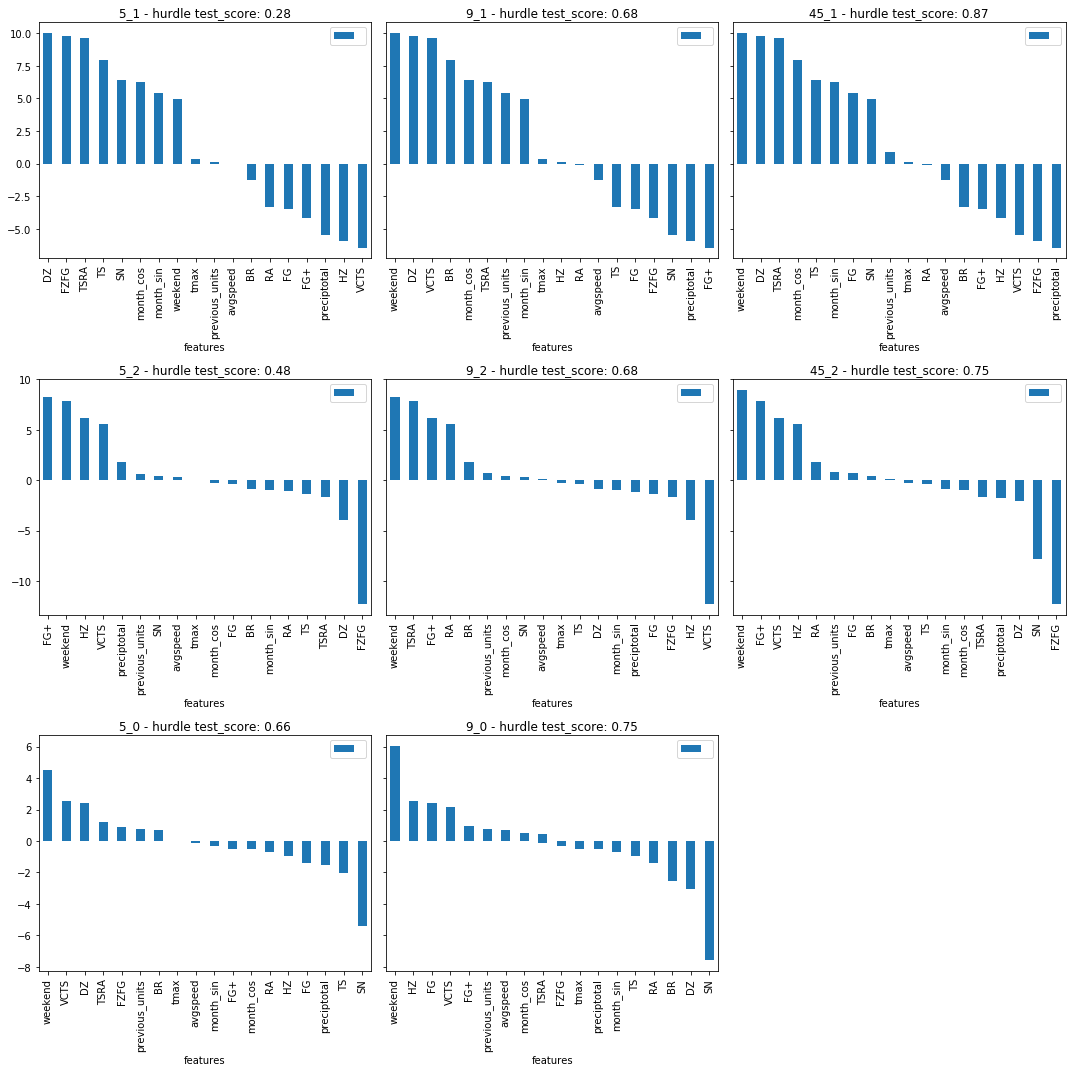

In [35]:
fig_clf, axes_clf = plt.subplots(nrows=3, ncols=3, figsize=(15,15), sharey='row')
fig_reg, axes_reg = plt.subplots(3,3, figsize=(15,15), sharey='row')

for row, city in enumerate(sales_data.city.unique()):
    # Get the keys for city
    city_keys = [key for key in list(models_dict.keys()) if key.endswith(str(city))]
    
    #Extract the models
    clf_models = []
    reg_models = []
    clf_scores = []
    scores = []
    for col, k in enumerate(city_keys):
        if models_dict[k]['clf']==None:
            clf_models.append(0)
            reg_models.append(0)
            clf_scores.append(0)
            scores.append(0)
        else:
            clf_models.append(models_dict[k]['clf']['clf'])
            reg_models.append(models_dict[k]['reg']['regressor'])
            clf_scores.append(models_dict[k]['clf_test_score'])
            scores.append(models_dict[k]['test_score'])
            X = models_dict[k]['features']
    
        # Plot classification feature importances
        for idx, model in enumerate(clf_models):
            if model != 0:
                pd.DataFrame({'features': X.to_list(),
                              'importance': model.coef_[0]}).\
                sort_values(by='importance', ascending=False).\
                set_index('features').plot(kind='bar', ax= axes_clf[row, col])
                axes_clf[row, col].legend([None])
                axes_clf[row, col].set_title(f'{k} - clf test_score: {round(clf_scores[idx],2)}')
            else:
                axes_clf[row, col].axis('off')
                axes_clf[row, col].set_visible(False)
                
                
        # Plot regression feature importances
        for idx, model in enumerate(reg_models):
            if model != 0:
                pd.DataFrame({'features': X.to_list(),
                              'importance': model.coef_}).\
                sort_values(by='importance', ascending=False).\
                set_index('features').plot(kind='bar', ax= axes_reg[row, col])
                axes_reg[row, col].legend([None])
                axes_reg[row, col].set_title(f'{k} - hurdle test_score: {round(scores[idx],2)}')
            else:
                axes_reg[row, col].axis('off')
                axes_reg[row, col].set_visible(False)        
        
        
fig_clf.tight_layout()
fig_reg.tight_layout()